In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

#import joypy

import pyBigWig

/home/alla/anaconda3/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
path = '/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/'

# gencode 25
metadata_pc_g25 = pd.read_csv(path+'tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()] 

# gencode 41
metadata_pc_g41 = pd.read_csv('tmp_res/metadata_pc_g41.txt', sep='\t')
metadata_pc_g41['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g41['tr_id'].tolist()] 
metadata_pc_g41[0:2]


# open metadata with scores and metrics
meta = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/METADATA_CURRENT.txt', sep='\t')
meta[0:2]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
0,ENST00000624431.1,274,316,42,274,316,14.0,FO538757.2,274,chr1:182667-182708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274-316
1,ENST00000624735.1,0,236,236,2,236,78.0,FO538757.1,86,chr1:200087-200236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-236


In [91]:
def prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta, file_counts, TCPseq_file, 
                                                        INITseq_file, metadata_pc_g25, 
                           tr_id, gene, l, p, l_tcp, p_tcp, fraq, cds, name,  
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9, frames=[1,2,3], ylim=None,ylim_tcp=None,
                                                frames_init = [1,2,3], zeros_init=True, 
                                                        p_init=10, ylim_init=100 
                                               ):
    
    # ELONG ribo-seq counts 
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
        
    # TCP ribo-seq counts 
    tcp = pd.read_csv(TCPseq_file)
    tcp.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq', 'tcpseq']  
    if tcp.iloc[0].Position == 1:
        tcp['Position'] = list(range(0, tcp.shape[0]))
        
    # INIT ribo-seq counts
    init = pd.read_csv(INITseq_file)
    init.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    if init.iloc[0].Position == 1:
        init['Position'] = list(range(0, init.shape[0]))
        
    print ('INIT frame1 counts:', init['Frame1'].sum())
    print ('ELONG frame1 counts:', f['Frame1'].sum())
    print ('INIT frame2 counts:', init['Frame2'].sum())
    print ('ELONG frame2 counts:', f['Frame2'].sum())
    print ('INIT frame3 counts:', init['Frame3'].sum())
    print ('ELONG frame3 counts:', f['Frame3'].sum())
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    d['frames'] = frames
    d['ylim'] = ylim
    d['tcp'] = tcp['tcpseq'].tolist() #only read counts
    d['p_tcp'] = p_tcp
    d['ylim_tcp'] = ylim_tcp
    d['l_tcp'] = l_tcp
    d['init'] = init
    d['frames_init'] = frames_init
    d['zeros_init'] = zeros_init
    d['ylim_init'] = ylim_init
    d['p_init'] = p_init 
    
    # p_init, ylim_init 
    
    return d


def trips_full_frames(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    frames = d['frames']
    ylim = d['ylim']
    tcpseq_counts = d['tcp']
    l_tcp = d['l_tcp']
    p_tcp = d['p_tcp']
    ylim_tcp = d['ylim_tcp']
    init = d['init']
    zeros_init = d['zeros_init']
    frames_init = d['frames_init']
    ylim_init = d['ylim_init']
    p_init = d['p_init']
    
    fig, axes = plt.subplots(7, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10, 10,10,1.5,1,1,1]}, sharex=True, sharey=False)

    init_plot = axes[0]
    tcp_plot = axes[1]
    main_plot = axes[2]
    #cds = axes[1]
    orfs = axes[3]
    red = axes[4]
    green = axes[5]
    blue = axes[6]

    # x 
    tcp_plot.set_xlim(f.Position.min(), f.Position.max()+1)
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    if ylim is None:
        main_plot.set_ylim(0, max_height+max_height/l)
        main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
        main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    else:
        main_plot.set_ylim(0, ylim)
        main_plot.set_yticks(np.arange(0, ylim, p))
        main_plot.set_yticklabels(np.arange(0, ylim, p, dtype=np.int64), fontsize=font1)
        
    
    # print (f[125:150])
    
    
    #####################################################################
    ################## PLOT IniTseq counts ###############################
    #####################################################################

    if zeros_init == True:
        if 1 in frames_init:
            t = init[['Position', 'Frame1']]
            init_plot.plot(t.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames_init:
            t = init[['Position', 'Frame2']]
            init_plot.plot(t.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames_init:
            t = init[['Position', 'Frame3']]
            init_plot.plot(t.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = init[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = init[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = init[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        if 1 in frames:
            init_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            init_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            init_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    
    #if xlims is not False:
    #    max_height_tcp = np.max(tcpseq_counts[xlims[0]:xlims[1]])
    #    print ('TCP max height:', max_height_tcp)
    #else:
    #    max_height_tcp = np.max(tcpseq_counts)
    #    print ('TCP max height:', max_height_tcp)
    #
    #if ylim_tcp is None:
    #    tcp_plot.set_ylim(0, max_height_tcp+max_height_tcp/l_tcp)
    #    tcp_plot.set_yticks(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp))
    #    tcp_plot.set_yticklabels(['']+list(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
    #else:
    
    # ylim_init, p_init
    init_plot.set_ylim(0, ylim_init)
    init_plot.set_yticks(np.arange(0, ylim_init, p_init))
    init_plot.set_yticklabels(['']+list(np.arange(0, ylim_init, p_init, dtype=np.int64))[1:], fontsize=font1)
        
    #####################################################################
    #####################################################################
    #####################################################################  
    
    #####################################################################
    ################## PLOT TCPseq counts ###############################
    #####################################################################

    
    tcp_plot.plot(tcpseq_counts, color = 'grey', linewidth=linewidth, linestyle='-')
    
    if xlims is not False:
        max_height_tcp = np.max(tcpseq_counts[xlims[0]:xlims[1]])
        print ('TCP max height:', max_height_tcp)
    else:
        max_height_tcp = np.max(tcpseq_counts)
        print ('TCP max height:', max_height_tcp)
    
    if ylim_tcp is None:
        tcp_plot.set_ylim(0, max_height_tcp+max_height_tcp/l_tcp)
        tcp_plot.set_yticks(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp))
        tcp_plot.set_yticklabels(['']+list(np.arange(0, max_height_tcp+max_height_tcp/l_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
    else:
        tcp_plot.set_ylim(0, ylim_tcp)
        tcp_plot.set_yticks(np.arange(0, ylim_tcp, p_tcp))
        tcp_plot.set_yticklabels(['']+list(np.arange(0, ylim_tcp, p_tcp, dtype=np.int64))[1:], fontsize=font1)
     
    ###################################################################
    ###################################################################

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        if 1 in frames:
            main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        if 1 in frames:
            main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    #main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            #if name == 'ENST00000381140_GTF3A':
                #N2 = 454 #stop codon of overlapping out-of-frame ORF 
                #rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            #elif name == 'ENST00000265806_R3HCC1':
            #    Nst = 288
            #    N2 = 420
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            #elif name == 'ENST00000472232_BAG1':
            #    Nst = 254 
            #    N2 = 302
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            #else:
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    init_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.12)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Add init ribo-seq in the right frame 

In [87]:
!ls profiles_known_genes/Init_seq/CCDC8.csv

profiles_known_genes/Init_seq/CCDC8.csv


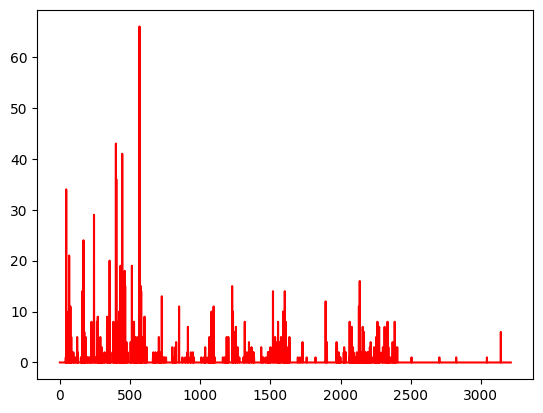

In [88]:
x = pd.read_csv('profiles_known_genes/Init_seq/CCDC8.csv')['Position'].tolist()
y = pd.read_csv('profiles_known_genes/Init_seq/CCDC8.csv')['Frame 1'].tolist()
plt.plot(x,y, color = 'red')

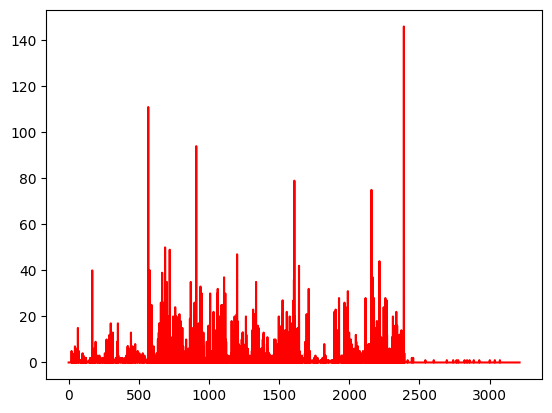

In [89]:
x = pd.read_csv('profiles_known_genes/CCDC8.csv')['Position'].tolist()
y = pd.read_csv('profiles_known_genes/CCDC8.csv')['Frame 1'].tolist()
plt.plot(x,y, color = 'red')

# CCDC8

INIT frame1 counts: 1338
ELONG frame1 counts: 5575
INIT frame2 counts: 1838
ELONG frame2 counts: 1917
INIT frame3 counts: 1546
ELONG frame3 counts: 1846
111
TCP max height: 20
0


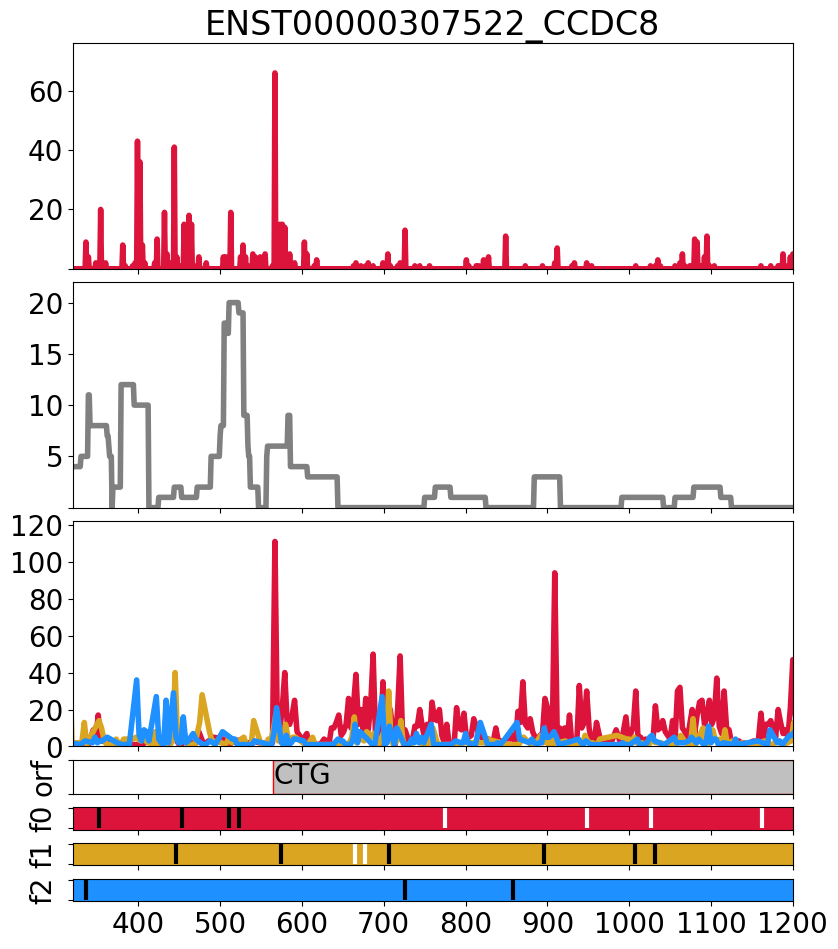

In [99]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'

pre_st = '565_CTG'

xlims = [320, 1200]

d1 = prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           TCPseq_file = 'profiles_known_genes/TCPseq/%s_TCPseq.csv' % gene, 
                           INITseq_file = 'profiles_known_genes/Init_seq/%s.csv' % gene,
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,
                             l_tcp=10, 
                             p_tcp=5,
                             fraq =100, 
                             cds = False,
                             name = 'CCDC8.png', 
                           figsize=(9, 11),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3],
                            frames_init = [1], zeros_init=True,
                             p_init=20, ylim_init=76
                           )

trips_full_frames(d1, name = 'CCDC8.png', font1=20, font2=24)

# EIF4G2

INIT frame1 counts: 158735
ELONG frame1 counts: 345362
INIT frame2 counts: 73152
ELONG frame2 counts: 158252
INIT frame3 counts: 68296
ELONG frame3 counts: 209395
18669
TCP max height: 25153
0


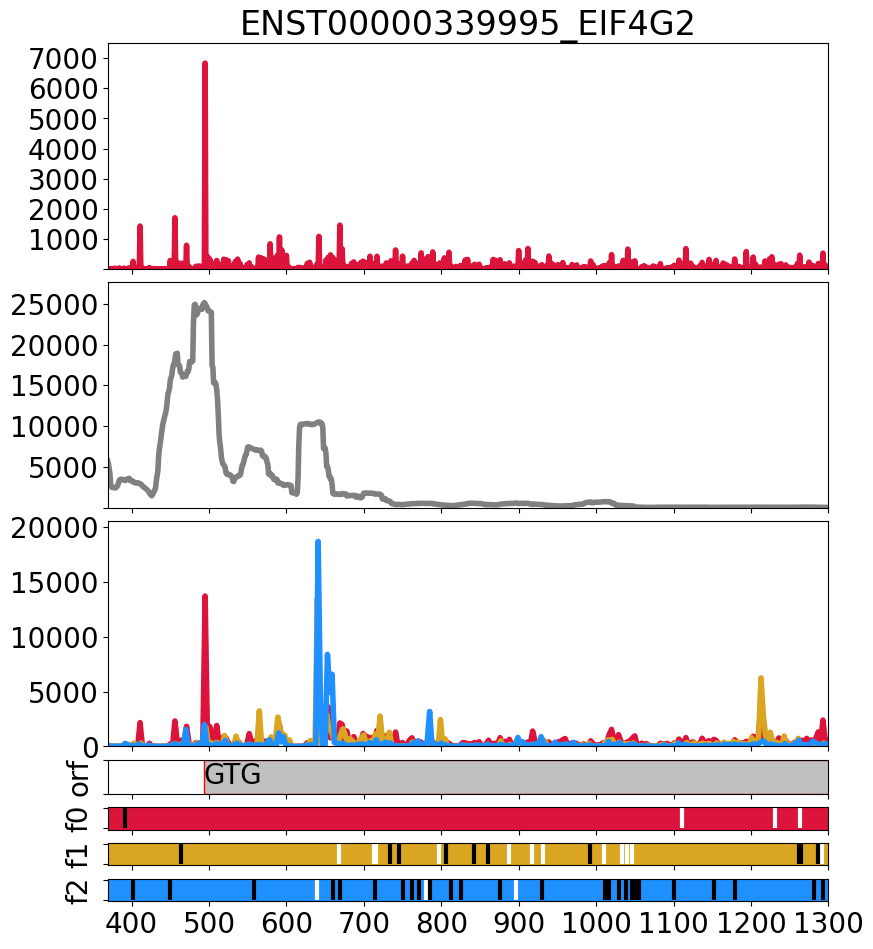

In [105]:
gene = 'EIF4G2'

tr_id = 'ENST00000339995'

pre_st = '493_GTG'

xlims = [370, 1300]

d1 = prepare_data_for_trips_frames_no_CDS_TCPseq_INITseq(meta = metadata_pc_g25, 
                           file_counts = 'profiles_known_genes/%s.csv' % (gene), 
                           TCPseq_file = 'profiles_known_genes/TCPseq/%s.csv' % gene, 
                           INITseq_file = 'profiles_known_genes/Init_seq/%s.csv' % gene,
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5000,
                             l_tcp=10, 
                             p_tcp=5000,
                             fraq =100, 
                             cds = False,
                             name = 'EIF4G2.png', 
                           figsize=(9, 11),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2,3],
                            frames_init = [1], zeros_init=True,
                             p_init=1000, ylim_init=7500
                           )

trips_full_frames(d1, name = 'EIF4G2.png', font1=20, font2=24)

# BAG1